<a href="https://colab.research.google.com/github/ghkdwnwsdud/ksebProject/blob/main/modules/mediapipe_detect_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 야구 동작을 인식하기 위한 모델 훈련 모듈
- name : 조병웅
- project : 야구 AI 캐스터
- stack : mediapipe(0.10.14), openCV(3.10.12), python(3.9.5)

In [ ]:
!pip install mediapipe


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
#라이브러리 임포트
import csv
import cv2
import mediapipe as mp
import numpy as np
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Accuracy: 0.8369565217391305
F1 Score: 0.5631067961165048
Confusion Matrix:
[[202   8]
 [ 37  29]]


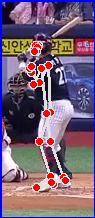

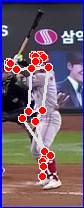

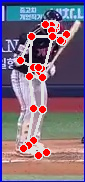

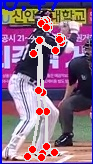

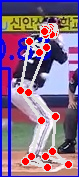

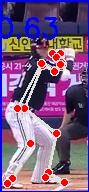

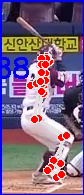

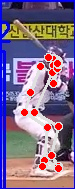

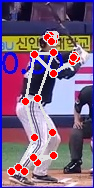

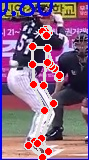

In [ ]:
"""
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

"""
from google.colab.patches import cv2_imshow
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix  # 추가된 부분

# Mediapipe setup
mp_drawing = mp.solutions.drawing_utils  # 추가된 부분: mediapipe drawing utils 추가
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Function to extract pose landmarks from an image
def extract_pose(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        return results.pose_landmarks.landmark, image, results.pose_landmarks  # 변경된 부분: 이미지와 포즈 랜드마크도 반환
    return None, image, None  # 변경된 부분: 이미지와 None을 반환

# Function to convert landmarks to a flat array
def landmarks_to_array(landmarks):
    if landmarks is None:
        return np.zeros(33 * 3)  # 33개의 랜드마크와 각 랜드마크의 x, y, z 좌표
    return np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks]).flatten()

# Function to load images and labels from folders
def load_images_from_folder(folder, label):
    images = []
    labels = []
    original_images = []  # 추가된 부분: 원본 이미지 리스트
    landmark_data = []  # 추가된 부분: 랜드마크 데이터 리스트

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        landmarks, orig_image, landmark_points = extract_pose(img_path)  # 변경된 부분: 추출된 포즈 데이터와 원본 이미지 및 랜드마크 데이터
        pose_vector = landmarks_to_array(landmarks)
        images.append(pose_vector)
        labels.append(label)
        original_images.append(orig_image)  # 추가된 부분: 원본 이미지 저장
        landmark_data.append(landmark_points)  # 추가된 부분: 랜드마크 데이터 저장

    return images, labels, original_images, landmark_data  # 변경된 부분: 원본 이미지와 랜드마크 데이터도 반환

# Load swing and no_swing images
swing_images, swing_labels, swing_orig_images, swing_landmarks = load_images_from_folder('data/swing', 1)
no_swing_images, no_swing_labels, no_swing_orig_images, no_swing_landmarks = load_images_from_folder('data/no_swing', 0)

# Combine the datasets
X = np.array(swing_images + no_swing_images)
y = np.array(swing_labels + no_swing_labels)
orig_images = swing_orig_images + no_swing_orig_images  # 추가된 부분: 원본 이미지 결합
landmarks_data = swing_landmarks + no_swing_landmarks  # 추가된 부분: 랜드마크 데이터 결합

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, orig_train, orig_test, landmarks_train, landmarks_test = train_test_split(
    X, y, orig_images, landmarks_data, test_size=0.4, random_state=42)  # 변경된 부분: 원본 이미지와 랜드마크 데이터도 분할

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)  # 추가된 부분: F1-스코어 계산
conf_matrix = confusion_matrix(y_test, y_pred)  # 추가된 부분: 혼동 행렬 계산

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')  # 추가된 부분: F1-스코어 출력
print(f'Confusion Matrix:\n{conf_matrix}')

# Visualize some of the test images with their pose landmarks  # 추가된 부분: 테스트 이미지의 포즈 랜드마크 시각화
for img, landmark in zip(orig_test[:10], landmarks_test[:10]):
    if landmark is not None:
        mp_drawing.draw_landmarks(img, landmark, mp_pose.POSE_CONNECTIONS)
    cv2_imshow(img)
    cv2.waitKey(0)
cv2.destroyAllWindows()

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Accuracy: 0.8840579710144928
F1 Score: 0.7419354838709677
Confusion Matrix:
[[99  5]
 [11 23]]
Top 10 important features:
Feature 0: 0.021785153076052666
Feature 1: 0.006897713989019394
Feature 2: 0.0029298067092895508
Feature 3: 0.004550165496766567
Feature 4: 0.0
Feature 5: 0.030077693983912468
Feature 6: 0.008475844748318195
Feature 7: 0.0009353143977932632
Feature 8: 0.0
Feature 9: 0.008136456832289696


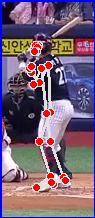

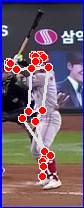

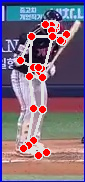

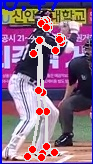

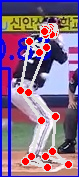

In [ ]:
import numpy as np
import cv2
import os
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from google.colab.patches import cv2_imshow

# Mediapipe setup
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Function to extract pose landmarks from an image
def extract_pose(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        return results.pose_landmarks.landmark, image, results.pose_landmarks
    return None, image, None

# Function to convert landmarks to a flat array
def landmarks_to_array(landmarks):
    if landmarks is None:
        return np.zeros(33 * 3)
    return np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks]).flatten()

# Function to load images and labels from folders
def load_images_from_folder(folder, label):
    images = []
    labels = []
    original_images = []
    landmark_data = []

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        landmarks, orig_image, landmark_points = extract_pose(img_path)
        pose_vector = landmarks_to_array(landmarks)
        images.append(pose_vector)
        labels.append(label)
        original_images.append(orig_image)
        landmark_data.append(landmark_points)

    return images, labels, original_images, landmark_data

# Load swing and no_swing images
swing_images, swing_labels, swing_orig_images, swing_landmarks = load_images_from_folder('data/swing', 1)
no_swing_images, no_swing_labels, no_swing_orig_images, no_swing_landmarks = load_images_from_folder('data/no_swing', 0)

# Combine the datasets
X = np.array(swing_images + no_swing_images)
y = np.array(swing_labels + no_swing_labels)
orig_images = swing_orig_images + no_swing_orig_images
landmarks_data = swing_landmarks + no_swing_landmarks

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, orig_train, orig_test, landmarks_train, landmarks_test = train_test_split(
    X, y, orig_images, landmarks_data, test_size=0.2, random_state=42)

# Train the XGBoost model
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Feature importance
feature_importance = model.feature_importances_
print("Top 10 important features:")
for i in range(10):
    print(f"Feature {i}: {feature_importance[i]}")

# Visualize some of the test images with their pose landmarks
for img, landmark in zip(orig_test[:5], landmarks_test[:5]):
    if landmark is not None:
        mp_drawing.draw_landmarks(img, landmark, mp_pose.POSE_CONNECTIONS)
    cv2_imshow(img)
    cv2.waitKey(0)
cv2.destroyAllWindows()

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Best threshold: 0.8000000000000003
Accuracy: 0.8405797101449275
Precision: 0.875
Recall: 0.4117647058823529
F1 Score: 0.56
Confusion Matrix:
[[102   2]
 [ 20  14]]
Top 10 important features:
Feature 0: 0.021785153076052666
Feature 1: 0.006897713989019394
Feature 2: 0.0029298067092895508
Feature 3: 0.004550165496766567
Feature 4: 0.0
Feature 5: 0.030077693983912468
Feature 6: 0.008475844748318195
Feature 7: 0.0009353143977932632
Feature 8: 0.0
Feature 9: 0.008136456832289696


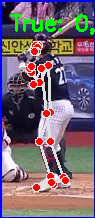

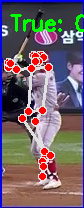

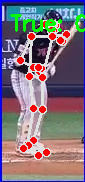

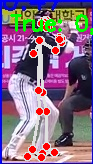

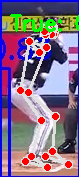

In [ ]:
import numpy as np
import cv2
import os
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from google.colab.patches import cv2_imshow

# Mediapipe setup
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Function to extract pose landmarks from an image
def extract_pose(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        return results.pose_landmarks.landmark, image, results.pose_landmarks
    return None, image, None

# Function to convert landmarks to a flat array
def landmarks_to_array(landmarks):
    if landmarks is None:
        return np.zeros(33 * 3)
    return np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks]).flatten()

# Function to load images and labels from folders
def load_images_from_folder(folder, label):
    images = []
    labels = []
    original_images = []
    landmark_data = []

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        landmarks, orig_image, landmark_points = extract_pose(img_path)
        pose_vector = landmarks_to_array(landmarks)
        images.append(pose_vector)
        labels.append(label)
        original_images.append(orig_image)
        landmark_data.append(landmark_points)

    return images, labels, original_images, landmark_data

# Load swing and no_swing images
swing_images, swing_labels, swing_orig_images, swing_landmarks = load_images_from_folder('data/swing', 1)
no_swing_images, no_swing_labels, no_swing_orig_images, no_swing_landmarks = load_images_from_folder('data/no_swing', 0)

# Combine the datasets
X = np.array(swing_images + no_swing_images)
y = np.array(swing_labels + no_swing_labels)
orig_images = swing_orig_images + no_swing_orig_images
landmarks_data = swing_landmarks + no_swing_landmarks

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, orig_train, orig_test, landmarks_train, landmarks_test = train_test_split(
    X, y, orig_images, landmarks_data, test_size=0.2, random_state=42)

# Train the XGBoost model
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Function to evaluate model with different thresholds
def evaluate_model(model, X, y, threshold):
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    return accuracy, precision, recall, f1, conf_matrix

# Find the best threshold for precision
thresholds = np.arange(0.5, 1.0, 0.05)
best_threshold = 0.5
best_precision = 0

for threshold in thresholds:
    _, precision, _, _, _ = evaluate_model(model, X_test, y_test, threshold)
    if precision > best_precision:
        best_precision = precision
        best_threshold = threshold

print(f"Best threshold: {best_threshold}")

# Evaluate the model with the best threshold
accuracy, precision, recall, f1, conf_matrix = evaluate_model(model, X_test, y_test, best_threshold)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Feature importance
feature_importance = model.feature_importances_
print("Top 10 important features:")
for i in range(10):
    print(f"Feature {i}: {feature_importance[i]}")

# Visualize some of the test images with their pose landmarks and predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

for img, landmark, true_label, pred_label, pred_prob in zip(orig_test[:5], landmarks_test[:5], y_test[:5], y_pred[:5], y_pred_proba[:5]):
    if landmark is not None:
        mp_drawing.draw_landmarks(img, landmark, mp_pose.POSE_CONNECTIONS)

    label_color = (0, 255, 0) if true_label == pred_label else (0, 0, 255)
    cv2.putText(img, f"True: {true_label}, Pred: {pred_label} ({pred_prob:.2f})", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)

    cv2_imshow(img)
    cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
"""
# Mediapipe setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Function to extract pose landmarks from an image
def extract_pose(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        return results.pose_landmarks.landmark
    return None

# Function to convert landmarks to a flat array
def landmarks_to_array(landmarks):
    if landmarks is None:
        return np.zeros(33 * 3)  # 33개의 랜드마크와 각 랜드마크의 x, y, z 좌표
    return np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks]).flatten()

# Function to load images and labels from folders
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        landmarks = extract_pose(img_path)
        pose_vector = landmarks_to_array(landmarks)
        images.append(pose_vector)
        labels.append(label)
    return images, labels

# Load swing and no_swing images
swing_images, swing_labels = load_images_from_folder('data/swing', 1)
no_swing_images, no_swing_labels = load_images_from_folder('data/no_swing', 0)

# Combine the datasets
X = np.array(swing_images + no_swing_images)
y = np.array(swing_labels + no_swing_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

In [ ]:
#버전정보 확인
#!python --version
#cv2.__version__
#mp.__version__
#!pip freeze > requirements.txt

In [ ]:

"""
def load_images_from_folder(folder, label): #이미지를 폴더에서 가져와 데이터로 만드는 함수
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

swing_images, swing_labels = load_images_from_folder('data/swing', 1)
no_swing_images, no_swing_labels = load_images_from_folder('data/no_swing', 0)

X_images = swing_images + no_swing_images
y_labels = swing_labels + no_swing_labels

# Now X_images contains all images and y_labels contains corresponding labels
#데이터 전처리

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def extract_pose(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        return results.pose_landmarks.landmark
    return None
def landmarks_to_array(landmarks):
    if landmarks is None:
        return np.zeros(33 * 3)  # 33개의 랜드마크와 각 랜드마크의 x, y, z 좌표
    return np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks]).flatten()
"""